In [2]:
# Let's do our imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import lightgbm as lgbm
import os
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from glob import glob
%matplotlib inline

In [7]:
# Let's get our data. We'll use the same method as before

# os.getcwd()
# rect = os.getcwd()
# print(rect)

os.chdir(r"C:\Users\Raul\Github\caterpillar")
# rect = os.getcwd()
# print(rect)

# Here we'll use that nifty code block that 
data = {}
for path in glob('data/*.csv'):
    df = pd.read_csv(path)
    bname = os.path.basename(path)
    name = os.path.splitext(bname)[0]
    data[name] = df

In [15]:
data['components'].head()

,component_id,name,component_type_id
0,9999,OTHER,OTHER
1,C-0001,SLEEVE,CP-024
2,C-0002,SLEEVE,CP-024
3,C-0003,SLEEVE-FLARED,CP-024
4,C-0004,NUT,CP-026


In [16]:
data['components'].describe()

,component_id,name,component_type_id
count,2048,2047,2048
unique,2048,297,29
top,C-0016,FLANGE,OTHER
freq,1,350,1006


In [17]:
data['bill_of_materials'].head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
data['bill_of_materials'].describe()

,quantity_1,quantity_2,quantity_3,quantity_4,quantity_5,quantity_6,quantity_7,quantity_8
count,19149.000000,14786.000000,4798.000000,608.000000,92.000000,26.000000,7.0,1.0
mean,1.559873,1.526106,1.020634,1.027961,1.032609,1.153846,1.0,1.0
std,0.507444,0.510851,0.160100,0.209041,0.178583,0.367946,0.0,NaN
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
50%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
75%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
max,6.000000,6.000000,4.000000,4.000000,2.000000,2.000000,1.0,1.0


In [19]:
data['tube'].head()

,tube_assembly_id,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00001,SP-0035,12.70,1.65,164.0,5,38.10,N,N,N,N,EF-003,EF-003,0,0,0
1,TA-00002,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00003,SP-0019,6.35,0.71,127.0,7,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00004,SP-0019,6.35,0.71,137.0,9,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00005,SP-0029,19.05,1.24,109.0,4,50.80,N,N,N,N,EF-003,EF-003,0,0,0


In [20]:
data['tube'].describe()

,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other
count,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000,21198.000000
mean,23.687764,1.578402,100.312844,3.748137,49.350767,0.044485,0.006746,0.022644
std,25.396277,0.745749,70.542771,2.265405,196.468480,0.260737,0.100015,0.199676
min,3.180000,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.520000,0.890000,48.000000,2.000000,19.050000,0.000000,0.000000,0.000000
50%,15.880000,1.650000,86.000000,3.000000,38.100000,0.000000,0.000000,0.000000
75%,25.400000,1.650000,135.000000,5.000000,50.800000,0.000000,0.000000,0.000000
max,203.200000,7.900000,1333.000000,17.000000,9999.000000,5.000000,5.000000,8.000000


In [29]:
# Alright, let's do our feature engineering to set up our pipeline

def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))


def organize(X):
    X = X.copy()
    
    # We'll create a list for duplicate and meaningless columns
    duplicates =[]
    meaningless = []
    
    # Let's pull month and year out of quote date
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    
    # Let's get the tube dataframe
    tube = pd.read_csv('data/tube.csv')
    # What features do we want to merge from tube
    tubefeats = ['tube_assembly_id', 'diameter', 'wall', 'length', 'num_bends', 'bend_radius']
    # now let's merge over
    X = X.merge(tube[tubefeats], how='left')
    
    # Now let's get the bill of materials csv, engineer features, then merge
    billmat = pd.read_csv('data/bill_of_materials.csv')
    # We'll separate the numeric and non numeric columns
    numcols = billmat.select_dtypes(include='number').columns.tolist()
    objcols = billmat.select_dtypes(exclude='number').columns.tolist()    
    # and we'll take care of the null values for numeric columns
    billmat[numcols] = billmat[numcols].fillna(0)
    # Now let's engineer a new feature total components
    billmat['comps_total'] = billmat[numcols].sum(axis=1)
    # Now let's work with the non numeric columns
    obj = billmat[objcols].drop(['tube_assembly_id'], axis=1)
    obj = obj.notnull().astype(int)
    # so that we can engineer new feature distinct components
    billmat['comps_dist'] = obj.sum(axis=1)
    
    # Now let's choose the features we want to merge for billmat
    matfeats = ['tube_assembly_id', 'component_id_1', 'comps_total', 'comps_dist']
    X = X.merge(billmat[matfeats], how='left')
    
    # Now let's get the components csv so we can merge that
    components = pd.read_csv('data/components.csv')
    components = components.rename(columns={'component_id': 'component_id_1'})
    compfeats = ['component_id_1', 'component_type_id']
    X = X.merge(components[compfeats], how='left')

    
    # Now we can add quote_date & tube_assembly_id
    meaningless = meaningless + ['quote_date', 'tube_assembly_id']
    
    todrop = duplicates + meaningless
    X = X.drop(columns=todrop)
    
    return X

# Now let's import train and test csv's
trainval = pd.read_csv('data/train_set.csv')
test = pd.read_csv('data/test_set.csv')

# So we're going to split on tube_assembly_id
trainval_assemblies = trainval['tube_assembly_id'].unique()
train_assemblies, val_assemblies = train_test_split(trainval_assemblies, random_state=42)
# Now we use our arrays of assemblies to split our dataframe
train = trainval[trainval['tube_assembly_id'].isin(train_assemblies)]
val = trainval[trainval['tube_assembly_id'].isin(val_assemblies)]

# Now we organize train, val and test
train = organize(train)
val = organize(val)
test = organize(test)

# Now let's Arrange x matrix and y vector
target = 'cost'
xtrain = train.drop(columns=target)
xval = val.drop(columns=target)
xtest = test.drop(columns='id')

ytrain = train[target]
yval = val[target]

ytrainlog = np.log1p(ytrain)
yvallog = np.log1p(yval)

In [30]:
 xtrain.head()

,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,quote_date_year,quote_date_month,diameter,wall,length,num_bends,bend_radius,component_id_1,comps_total,comps_dist,component_type_id
0,S-0066,0,0,Yes,1,2013,7,6.35,0.71,137.0,9,19.05,C-1312,2.0,1,CP-028
1,S-0066,0,0,Yes,2,2013,7,6.35,0.71,137.0,9,19.05,C-1312,2.0,1,CP-028
2,S-0066,0,0,Yes,5,2013,7,6.35,0.71,137.0,9,19.05,C-1312,2.0,1,CP-028
3,S-0066,0,0,Yes,10,2013,7,6.35,0.71,137.0,9,19.05,C-1312,2.0,1,CP-028
4,S-0066,0,0,Yes,25,2013,7,6.35,0.71,137.0,9,19.05,C-1312,2.0,1,CP-028


In [33]:
# Now let's make our pipeline
pipeline =  make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
)

# and fit our pipeline
pipeline.fit(xtrain, ytrainlog)

# and validate
ypredlog = pipeline.predict(xval)
print('Validation Error', rmse(yvallog, ypredlog))

Validation Error 0.30754582461473384


In [45]:
# Now let's use XGBoost in our pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=1000, n_job=-1)
)

# and fit our pipeline
pipeline.fit(xtrain, ytrainlog)

# and validate
ypredlog = pipeline.predict(xval)
print('Validation Error', rmse(yvallog, ypredlog))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:30:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Error 0.27665812585263716


In [37]:
# let's generate a submission using that score
def generate_submission(estimator, xtest, filename):
    ypredlog = estimator.predict(xtest)
    ypred = np.expm1(ypredlog)
    submission = pd.read_csv('data/sample_submission.csv')
    submission['cost'] = ypred
    submission.to_csv(filename, index=False)

generate_submission(pipeline, xtest, 'xgboostsub_01.csv')

In [38]:
# Now let's try early stopping
encoder = ce.OrdinalEncoder()
xtrain_encoded = encoder.fit_transform(xtrain)
xval_encoded = encoder.transform(xval)

In [39]:
eval_set = [ 
    (xtrain_encoded, ytrainlog),
    (xval_encoded, yvallog)
]

In [41]:
model = XGBRegressor(n_estimators=1000, n_job=-1)

model.fit(xtrain_encoded,
          ytrainlog,
          eval_set = eval_set,
          eval_metric = 'rmse',
          early_stopping_rounds=10
         )

[01:27:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.71924	validation_1-rmse:1.70846
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.56516	validation_1-rmse:1.55498
[2]	validation_0-rmse:1.42779	validation_1-rmse:1.41846
[3]	validation_0-rmse:1.30338	validation_1-rmse:1.29429
[4]	validation_0-rmse:1.19168	validation_1-rmse:1.18295
[5]	validation_0-rmse:1.09322	validation_1-rmse:1.08553
[6]	validation_0-rmse:1.0052	validation_1-rmse:0.997831


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[7]	validation_0-rmse:0.927625	validation_1-rmse:0.922044
[8]	validation_0-rmse:0.859918	validation_1-rmse:0.857038
[9]	validation_0-rmse:0.799931	validation_1-rmse:0.798449
[10]	validation_0-rmse:0.747477	validation_1-rmse:0.747753
[11]	validation_0-rmse:0.700331	validation_1-rmse:0.700602
[12]	validation_0-rmse:0.660555	validation_1-rmse:0.662632
[13]	validation_0-rmse:0.623151	validation_1-rmse:0.625617
[14]	validation_0-rmse:0.59235	validation_1-rmse:0.596398
[15]	validation_0-rmse:0.563785	validation_1-rmse:0.568356
[16]	validation_0-rmse:0.540569	validation_1-rmse:0.546305
[17]	validation_0-rmse:0.519739	validation_1-rmse:0.525935
[18]	validation_0-rmse:0.501833	validation_1-rmse:0.508539
[19]	validation_0-rmse:0.48603	validation_1-rmse:0.493281
[20]	validation_0-rmse:0.472825	validation_1-rmse:0.481602
[21]	validation_0-rmse:0.461476	validation_1-rmse:0.471224
[22]	validation_0-rmse:0.4487	validation_1-rmse:0.459724
[23]	validation_0-rmse:0.440285	validation_1-rmse:0.450638
[24]

[146]	validation_0-rmse:0.294581	validation_1-rmse:0.320569
[147]	validation_0-rmse:0.293923	validation_1-rmse:0.320156
[148]	validation_0-rmse:0.293595	validation_1-rmse:0.320171
[149]	validation_0-rmse:0.29335	validation_1-rmse:0.319753
[150]	validation_0-rmse:0.292959	validation_1-rmse:0.319387
[151]	validation_0-rmse:0.292524	validation_1-rmse:0.31894
[152]	validation_0-rmse:0.292171	validation_1-rmse:0.318741
[153]	validation_0-rmse:0.291751	validation_1-rmse:0.318621
[154]	validation_0-rmse:0.291516	validation_1-rmse:0.318472
[155]	validation_0-rmse:0.291253	validation_1-rmse:0.318277
[156]	validation_0-rmse:0.291053	validation_1-rmse:0.318098
[157]	validation_0-rmse:0.290955	validation_1-rmse:0.31809
[158]	validation_0-rmse:0.290714	validation_1-rmse:0.317969
[159]	validation_0-rmse:0.290539	validation_1-rmse:0.317848
[160]	validation_0-rmse:0.290258	validation_1-rmse:0.317653
[161]	validation_0-rmse:0.290127	validation_1-rmse:0.317655
[162]	validation_0-rmse:0.289928	validation

[283]	validation_0-rmse:0.264835	validation_1-rmse:0.29897
[284]	validation_0-rmse:0.26467	validation_1-rmse:0.298884
[285]	validation_0-rmse:0.264655	validation_1-rmse:0.298873
[286]	validation_0-rmse:0.264552	validation_1-rmse:0.298784
[287]	validation_0-rmse:0.264507	validation_1-rmse:0.298687
[288]	validation_0-rmse:0.264414	validation_1-rmse:0.298717
[289]	validation_0-rmse:0.264357	validation_1-rmse:0.298587
[290]	validation_0-rmse:0.264171	validation_1-rmse:0.298683
[291]	validation_0-rmse:0.264044	validation_1-rmse:0.298681
[292]	validation_0-rmse:0.263621	validation_1-rmse:0.298266
[293]	validation_0-rmse:0.263391	validation_1-rmse:0.298007
[294]	validation_0-rmse:0.263208	validation_1-rmse:0.298033
[295]	validation_0-rmse:0.263027	validation_1-rmse:0.297937
[296]	validation_0-rmse:0.262905	validation_1-rmse:0.297927
[297]	validation_0-rmse:0.262808	validation_1-rmse:0.297894
[298]	validation_0-rmse:0.262668	validation_1-rmse:0.297106
[299]	validation_0-rmse:0.262595	validatio

[421]	validation_0-rmse:0.247755	validation_1-rmse:0.288001
[422]	validation_0-rmse:0.247641	validation_1-rmse:0.287988
[423]	validation_0-rmse:0.247565	validation_1-rmse:0.287946
[424]	validation_0-rmse:0.247535	validation_1-rmse:0.287932
[425]	validation_0-rmse:0.247506	validation_1-rmse:0.287923
[426]	validation_0-rmse:0.247402	validation_1-rmse:0.287891
[427]	validation_0-rmse:0.247337	validation_1-rmse:0.287914
[428]	validation_0-rmse:0.247301	validation_1-rmse:0.288059
[429]	validation_0-rmse:0.24719	validation_1-rmse:0.288054
[430]	validation_0-rmse:0.247098	validation_1-rmse:0.287923
[431]	validation_0-rmse:0.247006	validation_1-rmse:0.287963
[432]	validation_0-rmse:0.246977	validation_1-rmse:0.287977
[433]	validation_0-rmse:0.246898	validation_1-rmse:0.287852
[434]	validation_0-rmse:0.246852	validation_1-rmse:0.28784
[435]	validation_0-rmse:0.246827	validation_1-rmse:0.287836
[436]	validation_0-rmse:0.246757	validation_1-rmse:0.287783
[437]	validation_0-rmse:0.24668	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_job=-1, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

(0.2, 0.4)

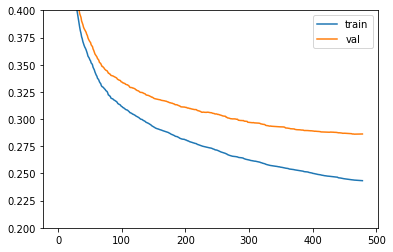

In [46]:
results = model.evals_result()

train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']

epochs = range(0, len(train_rmse))

plt.plot(epochs, train_rmse, label='train')
plt.plot(epochs, val_rmse, label='val')
plt.legend();
plt.ylim(0.2, 0.4)

In [47]:
# Now let's use the best iteration information we just learned

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(n_estimators=469, n_job=-1)
)

# and fit our pipeline
pipeline.fit(xtrain, ytrainlog)

# and validate
ypredlog = pipeline.predict(xval)
print('Validation Error', rmse(yvallog, ypredlog))

generate_submission(pipeline, xtest, 'xgboostsub_02.csv')

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:33:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Error 0.2861319072017634
